<a href="https://colab.research.google.com/github/SFStefenon/AutoTFT/blob/main/TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install neuralforecast

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from ray import tune
from neuralforecast.auto import AutoTFT
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MAE
from numpy.lib.function_base import append

from statsmodels.tools.eval_measures import rmse #root mean squared error
from statsmodels.tools.eval_measures import rmspe #root mean squared percentage error
from statsmodels.tools.eval_measures import maxabs #maximum absolute error
from statsmodels.tools.eval_measures import meanabs #mean absolute error
from statsmodels.tools.eval_measures import medianabs #median absolute error
from statsmodels.tools.eval_measures import vare #variance of error
from statsmodels.tools.eval_measures import stde #standard deviation of error
from statsmodels.tools.eval_measures import iqr #interquartile range of error

In [ ]:
torch.cuda.is_available()

True

# Load Data

In [ ]:
# Load the data
Y_df = pd.read_csv('data.csv', sep=';')

# Set the threshold until the max
max = np.where(Y_df.y==np.max(Y_df.y))
Y_df = Y_df[0:max[-1][-1]]

In [ ]:
len(Y_df)

481

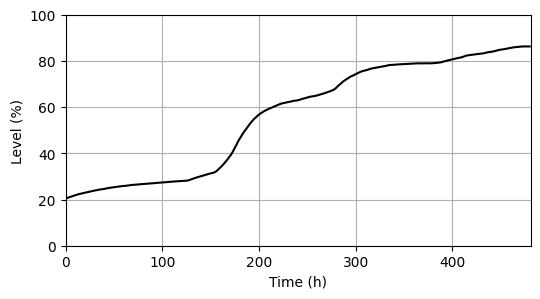

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(Y_df.y, 'k')
plt.axis([0, len(list(Y_df.y)), 0, 100])
plt.xlabel('Time (h)')
plt.ylabel('Level (%)')
plt.grid(linestyle='-', which='both')
# plt.savefig('Singals_Ori.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
Y_df['ds'] = pd.to_datetime(Y_df['ds'], format='%d/%m/%y %H:%M')
Y_df.head()

,unique_id,ds,y
0,Level,2020-06-01 00:00:00,20.46
1,Level,2020-06-01 01:00:00,20.61
2,Level,2020-06-01 02:00:00,20.75
3,Level,2020-06-01 03:00:00,20.90
4,Level,2020-06-01 04:00:00,21.02


# Run the experiment

In [ ]:
start = time.time()

horizon = 1
models = [AutoTFT(h=horizon,
                  loss=MAE(),
                  config=None,
                  num_samples=10)]

In [ ]:
# Configuration of hyperparameter search space.
config = {
      "input_size": tune.choice([horizon]),
      "hidden_size": tune.choice([8, 32]),
      "n_head": tune.choice([2, 8]),
      "learning_rate": tune.loguniform(1e-4, 1e-1),
      "scaler_type": tune.choice(['robust', 'standard']),
      "max_steps": tune.choice([500, 1000]),
      "windows_batch_size": tune.choice([8, 32]),
      "check_val_every_n_epoch": tune.choice([100]),
      "random_seed": tune.randint(1, 20),
}

In [ ]:
%%capture
nf = NeuralForecast(
    models=models,
    freq='H')

nf.fit(df=Y_df)
Y_hat_df = nf.predict()

end = time.time()
time_s = end - start #save time

INFO:lightning_fabric.utilities.seed:Global seed set to 10


In [ ]:
y_pred = Y_hat_df.AutoTFT
y_true = Y_df[-horizon:].y

In [ ]:
# rmse & rmspe & maxabs & meanabs & medianabs & time
print(f'{(rmse(y_true, y_pred)):.2E} & {(rmspe(y_true, y_pred)):.2E} & {(maxabs(y_true, y_pred)):.2E} & {(meanabs(y_true, y_pred)):.2E} & {(medianabs(y_true, y_pred)):.2E} & {time_s:.2f}')

7.97E-02 & 9.24E-03 & 7.97E-02 & 7.97E-02 & 7.97E-02 & 362.14


In [ ]:
# rmse & rmspe & maxabs & meanabs & medianabs & vare & stde & iqr & time
print(f'{(rmse(y_true, y_pred)):.2E} & {(rmspe(y_true, y_pred)):.2E} & {(maxabs(y_true, y_pred)):.2E} & {(meanabs(y_true, y_pred)):.2E} & {(medianabs(y_true, y_pred)):.2E} & {(vare(y_true, y_pred)):.2E} & {(stde(y_true, y_pred)):.2E} & {(iqr(y_true, y_pred)):.2E} & {time_s:.2f}')

7.97E-02 & 9.24E-03 & 7.97E-02 & 7.97E-02 & 7.97E-02 & 0.00E+00 & 0.00E+00 & 0.00E+00 & 362.14


## Plots

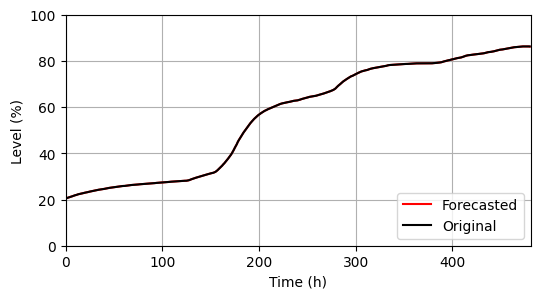

In [ ]:
pred = pd.concat([Y_df[:-horizon].y, Y_hat_df.AutoTFT], ignore_index=True)

plt.figure(figsize=(6, 3))
plt.plot(pred, 'r', label='Forecasted')
plt.plot(list(Y_df.y), 'k', label='Original')
plt.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.axis([0, len(list(Y_df.y)), 0, 100])
plt.xlabel('Time (h)')
plt.ylabel('Level (%)')
plt.grid(linestyle='-', which='both')
#plt.savefig('Singals_0.pdf', bbox_inches = 'tight')
plt.show()

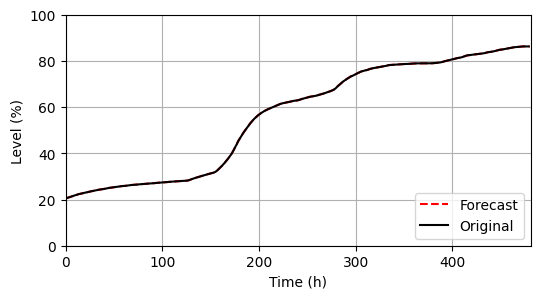

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(pred, '--r', label='Forecast')
plt.plot(list(Y_df[:-horizon].y), 'k', label='Original')
plt.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.axis([0, len(list(Y_df.y)), 0, 100])
plt.xlabel('Time (h)')
plt.ylabel('Level (%)')
plt.grid(linestyle='-', which='both')
#plt.savefig('Singals_0.pdf', bbox_inches = 'tight')
plt.show()

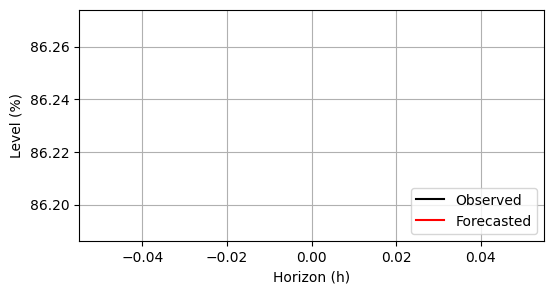

In [ ]:
plt.figure(figsize=(6, 3))
# To skip the first position where h = 1 is position 0
#plt.plot(np.concatenate((0, list(y_true)), axis=None), 'k', label='Observed')
#plt.plot(np.concatenate((0, list(y_pred)), axis=None), 'r', label='Forecasted')
#plt.axis([1, 30, 84.5, 87])
plt.plot(list(y_true), 'k', label='Observed')
plt.plot(list(y_pred), 'r', label='Forecasted')
plt.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.xlabel('Horizon (h)')
plt.ylabel('Level (%)')
plt.grid(linestyle='-', which='both')
#plt.savefig('Singals_3.pdf', bbox_inches = 'tight')
plt.show()

# Benchmarking

In [ ]:
y_pred = [78.330, 78.370, 78.370, 78.410, 78.410, 78.440, 78.480, 78.520, 78.560, 78.600, 78.600, 78.630, 78.630, 78.670, 78.670, 78.670, 78.710, 78.750, 78.750, 78.790, 78.820, 78.860, 78.900, 78.940, 78.940, 78.940, 78.940, 78.940, 78.940, 78.940, 78.940, 78.940, 78.980, 78.980, 78.980, 78.980, 78.980, 78.980, 78.980, 78.980, 78.980, 78.980, 79.010, 79.050, 79.090, 79.130, 79.170, 79.210, 79.280, 79.320, 79.400, 79.470, 79.630, 79.740, 79.850, 79.970, 80.080, 80.200, 80.280, 80.350, 80.470, 80.580, 80.700, 80.770, 80.890, 81,	81.120, 81.200, 81.270, 81.350, 81.430, 81.500, 81.620, 81.770, 81.930, 82.080, 82.230, 82.350, 82.430, 82.470, 82.540, 82.580, 82.660, 82.700, 82.770, 82.810, 82.850, 82.930, 82.970, 83.010, 83.080, 83.120, 83.160, 83.200, 83.280, 83.350, 83.470, 83.630, 83.700, 83.780, 83.820, 83.860, 83.940, 84.010, 84.090, 84.170, 84.280, 84.360, 84.480, 84.600, 84.710, 84.830, 84.870, 84.910, 84.980, 85.060, 85.140, 85.220, 85.300, 85.370, 85.450, 85.530, 85.610, 85.680, 85.760, 85.840, 85.920, 85.960, 86,	86.070, 86.110, 86.150, 86.190, 86.230, 86.270, 86.270, 86.270, 86.270, 86.270, 86.270, 86.270, 86.270, 86.2700000000000]

ANFIS

In [ ]:
# ANFIS1
y_true = [78.3386441670038, 78.3823589894318, 78.4322556161527, 78.4281646244320, 78.4627367184292, 78.4697510135228, 78.5012091569538, 78.5380990577371, 78.5862876033664, 78.6175501467604, 78.6542393154759, 78.6540501815369, 78.6768776317542, 78.6839842134931, 78.7260890197141, 78.7273228484725, 78.7255311486904, 78.7571383958320, 78.8123728011204, 78.8106944253730, 78.8326812612924, 78.8713420027053, 78.9153712303720, 78.9473397793516, 78.9880568178251, 78.9879165508572, 78.9806282873104, 78.9826170782426, 78.9923160036867, 78.9923160036867, 78.9923160036867, 78.9923160036867, 78.9923160036867, 79.0294720821925, 79.0386671359419, 79.0293375867292, 79.0218052551434, 79.0314923958481, 79.0314923958481, 79.0314923958481, 79.0314923958481, 79.0314923958481, 79.0314923958481, 79.0591994446852, 79.1028420081184, 79.1418410783086, 79.1732824992713, 79.2099958502850, 79.2489915517335, 79.3138687440366, 79.3620773726725, 79.4271867647479, 79.4994869213148, 79.6409884413460, 79.7672071339425, 79.8598181682861, 79.9589476156113, 80.0795607109542, 80.1900081272317, 80.2803051493198, 80.3434051346344, 80.4407959765234, 80.5708714224848, 80.6806673249496, 80.7611376762514, 80.8463099749635, 80.9694870769667, 81.0865249340154, 81.1760271944537, 81.2394901403437, 81.3086340169538, 81.3972171166227, 81.4721680122252, 81.5577198380136, 81.7005130157417, 81.8581748992473, 82.0024237988789, 82.1390705371433, 82.2736143817823, 82.3706872936271, 82.4240385779562, 82.4638742665733, 82.5410818707307, 82.5892592894879, 82.6640966765127, 82.7036612919305, 82.7667382400482, 82.8039956245554, 82.8459357471036, 82.9350224658911, 82.9610647165077, 82.9978594336438, 83.0788683427909, 83.1081497949868, 83.1410091989522, 83.1927338036608, 83.2834018886767, 83.3552448171098, 83.4858284335243, 83.6517324952315, 83.6800383819027, 83.7500024288987, 83.7907112558780, 83.8289766558412, 83.9295707712105, 83.9958055202962, 84.0703737687792, 84.1505691349482, 84.2688614829922, 84.3348031998570, 84.4615482144478, 84.5864539525475, 84.6823602379577, 84.8130768789624, 84.8214119078783, 84.8510405533012, 84.9454761823971, 85.0298497698240, 85.1038118768012, 85.1808423466444, 85.2615529160516, 85.3242643846834, 85.4068222109810, 85.4880367265451, 85.5676384405899, 85.6298428534496, 85.7125563819125, 85.7939279827731, 85.8827095467423, 85.9042326321791, 85.9320070667949, 86.0310742971510, 86.0593519166094, 86.0914602839442, 86.1364414666396, 86.1761609600804, 86.2290416749800, 86.2103818515555, 86.2069623492491, 86.2143333013920, 86.2143333013920, 86.2143333013920, 86.2143333013920]

In [ ]:
# ANFIS2
y_true = [78.3309303640523, 78.3721262562985, 78.4175864194411, 78.4010698564968, 78.4534972186854, 78.4414839214378, 78.4844262318801, 78.5243668899349, 78.5681327115377, 78.6025852189865, 78.6401563776717, 78.6250157718296, 78.6639212034809, 78.6552779678056, 78.7125240358572, 78.6960161303358, 78.6970166928003, 78.7470675353139, 78.7931788384443, 78.7765712836208, 78.8234948175710, 78.8520473113662, 78.8984013675885, 78.9326264823285, 78.9725828177282, 78.9560662549780, 78.9544058955140, 78.9558728445112, 78.9613766725600, 78.9613766725600, 78.9613766725600, 78.9613766725600, 78.9613766725600, 79.0154643939330, 79.0019841476710, 78.9988568392158, 78.9948199601544, 79.0003237882077, 79.0003237882077, 79.0003237882077, 79.0003237882077, 79.0003237882077, 79.0003237882077, 79.0408895792323, 79.0848671159027, 79.1231291096711, 79.1575816170212, 79.1951527756429, 79.2340998912787, 79.3136127979186, 79.3424497288717, 79.4331390845187, 79.4961440855737, 79.6882447431397, 79.7750222719520, 79.8781267124943, 79.9882032837943, 80.0988175753298, 80.2186622465393, 80.2808217422018, 80.3445429034657, 80.4799859095061, 80.5912513407210, 80.7110050200140, 80.7541387572617, 80.8888396317119, 80.9946922267540, 81.1199497341400, 81.1766054017139, 81.2403265629804, 81.3216818477140, 81.4058617341679, 81.4712432548920, 81.6052193119889, 81.7650686364170, 81.9254297908002, 82.0601314160427, 82.2012734014909, 82.3057500743420, 82.3686343873617, 82.3918807495681, 82.4753281167292, 82.5111358247317, 82.6073290084602, 82.6297682185125, 82.7102816877926, 82.7350817396108, 82.7771872020356, 82.8671943796067, 82.8967891200919, 82.9326089273251, 83.0080849547824, 83.0424257138444, 83.0790273481770, 83.1149468044445, 83.2121095124484, 83.2781421728422, 83.4120272380215, 83.5798946646835, 83.6151883845797, 83.6847852244251, 83.7068036312721, 83.7561072634180, 83.8492330922703, 83.9207695807563, 84.0005669246318, 84.0737391549015, 84.1932083969295, 84.2596164865074, 84.3892529577750, 84.5047270047621, 84.6107073434583, 84.7254149238134, 84.7348626551989, 84.7714982717031, 84.8525691191699, 84.9465014276277, 85.0237105370491, 85.0971101600071, 85.1736284342464, 85.2380007351828, 85.3192650279989, 85.3979410863607, 85.4768445374109, 85.5398408813242, 85.6211051741403, 85.6997812325021, 85.7786846835523, 85.8011152364879, 85.8384019926615, 85.9193818482109, 85.9537226072729, 85.9903242416057, 86.0262436978730, 86.0693186845733, 86.1082658002044, 86.0931251945319, 86.0914648350744, 86.0929317840149, 86.0984356121071, 86.0984356121071, 86.0984356121071, 86.0984356121071]

In [ ]:
# ANFIS3
y_true = [78.3308526038711, 78.3750135185982, 78.4151782416576, 78.3951162048605, 78.4515270451458, 78.4377857207757, 78.4774372026556, 78.5256465349428, 78.5644526676508, 78.6019117958075, 78.6408870527988, 78.6211786016752, 78.6628314416467, 78.6533687598161, 78.7092671888268, 78.6936776040091, 78.6887269253087, 78.7497462732218, 78.7930272753595, 78.7699729631191, 78.8250252413706, 78.8555527813057, 78.8971407861646, 78.9365945201035, 78.9754119873653, 78.9553842747549, 78.9527828254387, 78.9561397275387, 78.9574945084737, 78.9574945084737, 78.9574945084737, 78.9574945084737, 78.9574945084737, 79.0165002063797, 78.9994156983068, 78.9934592469203, 78.9954614135559, 78.9968162107075, 78.9968162107075, 78.9968162107075, 78.9968162107075, 78.9968162107075, 78.9968162107075, 79.0410693741984, 79.0872600444927, 79.1247125746458, 79.1621777677964, 79.2011595524713, 79.2404803569772, 79.3240492085348, 79.3505594394801, 79.4444131098585, 79.5124006628176, 79.7109505545504, 79.7998079385640, 79.8974975807816, 80.0215308590978, 80.1270980318080, 80.2485040413897, 80.3086563249855, 80.3694967554337, 80.5144129983870, 80.6230678780174, 80.7414664826690, 80.7855418757902, 80.9243706248193, 81.0346947434855, 81.1544563654148, 81.2132855015300, 81.2741550513206, 81.3601144308379, 81.4416232243236, 81.5050569376080, 81.6466136878666, 81.8128777073450, 81.9731867773144, 82.1122235176639, 82.2572477809761, 82.3610582804848, 82.4185532285707, 82.4382551288046, 82.5236381541294, 82.5549051360126, 82.6501190990481, 82.6739076561930, 82.7525675407820, 82.7811224996165, 82.8173883519442, 82.9171837773184, 82.9404869388165, 82.9739191080878, 83.0594789429229, 83.0873862171142, 83.1222967355615, 83.1631445277746, 83.2624530779248, 83.3289505007489, 83.4674861254091, 83.6471313359409, 83.6705585490291, 83.7433587717473, 83.7699471956397, 83.8089582042439, 83.9102727713987, 83.9781281585366, 84.0577183257178, 84.1365279564788, 84.2589254210250, 84.3244843447865, 84.4576887391822, 84.5797736393624, 84.6807274851934, 84.8016701925303, 84.8032932441832, 84.8370485806235, 84.9269906769530, 85.0152044536611, 85.0920094024114, 85.1688422482954, 85.2471946680215, 85.3111502986695, 85.3941059652372, 85.4742748444786, 85.5524653757477, 85.6160821130559, 85.6990381123885, 85.7792072974949, 85.8573981492371, 85.8768068289647, 85.9136096526854, 86.0005280386861, 86.0284406531564, 86.0633567099557, 86.1042079199792, 86.1445723047911, 86.1839187364948, 86.1643207680649, 86.1617774620453, 86.1651411921226, 86.1664984943518, 86.1664984943518, 86.1664984943518, 86.1664984943518]

LSTM

In [ ]:
# LSTM sgdm
y_true = [77.6499473106544, 77.6991086210358, 77.7437526255791, 77.7759267593698, 77.8078543205577, 77.8306251807227, 77.8534319495191, 77.8787235956127, 77.9060811849698, 77.9351073287356, 77.9654596979567, 77.9877230494637, 78.0106375441545, 78.0272632405217, 78.0482602142924, 78.0635525034781, 78.0745261812531, 78.0913601476829, 78.1127521163996, 78.1285806411484, 78.1492161346957, 78.1712592465964, 78.1966658003107, 78.2246051094975, 78.2544475761519, 78.2765960200381, 78.2927979945541, 78.3044491485094, 78.3126770129319, 78.3183649401556, 78.3221951941783, 78.3246872532018, 78.3262361121723, 78.3362091360839, 78.3436182837090, 78.3490644261476, 78.3529808608858, 78.3557554011435, 78.3576777098811, 78.3589752084313, 78.3598274399514, 78.3603588876970, 78.3606700958363, 78.3676411581577, 78.3819902472902, 78.4019698098361, 78.4261674396245, 78.4534771508063, 78.4830514996791, 78.5210308622229, 78.5585458064665, 78.6046141867245, 78.6548240291446, 78.7283505429278, 78.8082448540238, 78.8927330760382, 78.9826411074948, 79.0741769969110, 79.1689446631589, 79.2570357178634, 79.3376338381361, 79.4235320724126, 79.5112113748097, 79.6024384499954, 79.6852102394259, 79.7725256676908, 79.8610332625204, 79.9526625143784, 80.0377803343978, 80.1156972768546, 80.1902914739466, 80.2623864302889, 80.3304596199073, 80.4064566475352, 80.4950647865328, 80.5954509566502, 80.7024921931321, 80.8143882765877, 80.9232776106355, 81.0210400567474, 81.1015807232097, 81.1754567476725, 81.2378851004249, 81.3003421800826, 81.3543822765253, 81.4085899465816, 81.4566117563911, 81.5000659882787, 81.5486862752793, 81.5928060138033, 81.6335886435100, 81.6782685566847, 81.7195778463196, 81.7583926830221, 81.7953067561658, 81.8393451017918, 81.8867014049650, 81.9472194185236, 82.0261465904789, 82.0999077073210, 82.1716770920713, 82.2332819402089, 82.2871065848629, 82.3434017433615, 82.3995149647940, 82.4576294939534, 82.5172569734518, 82.5843055701191, 82.6506838723325, 82.7248615292996, 82.8048563845637, 82.8871110897011, 82.9730332630653, 83.0450133117869, 83.1063452543254, 83.1657429185824, 83.2258060894758, 83.2864485862902, 83.3475602892224, 83.4090454419218, 83.4687686777707, 83.5291909349788, 83.5901494277500, 83.6515053093761, 83.7111088497869, 83.7714161993742, 83.8322310576197, 83.8934385169024, 83.9467700163509, 83.9941358951591, 84.0430626024816, 84.0871440384653, 84.1276010965801, 84.1653338865212, 84.2010605809179, 84.2353174153334, 84.2604199426347, 84.2786375883302, 84.2916700276424, 84.3008817885670, 84.3072783127849, 84.3116448023708, 84.3145605832456]

In [ ]:
# LSTM rmsprop
y_true = [78.8993689911326, 78.9742672146377, 79.0287669415631, 79.0575656639963, 79.0661789477299, 79.0551166953306, 79.0327408301117, 79.0084522317903, 78.9903566754418, 78.9849009573682, 78.9962002067352, 79.0201297187420, 79.0569145208125, 79.0998947587647, 79.1487544366417, 79.1955984433393, 79.2348489714370, 79.2682176657009, 79.2965256368375, 79.3154997577024, 79.3295735473270, 79.3406788900841, 79.3524760724740, 79.3679455109082, 79.3892512989095, 79.4120724311585, 79.4337205481130, 79.4519980415276, 79.4652291752672, 79.4725210213630, 79.4737706417378, 79.4696387552109, 79.4613797699744, 79.4561562610510, 79.4530944517416, 79.4523930364737, 79.4541214386014, 79.4579229657189, 79.4631752015476, 79.4691288526441, 79.4750011108426, 79.4800857730578, 79.4838585732701, 79.4901449776849, 79.5024400930978, 79.5227021368778, 79.5517713710013, 79.5893533446903, 79.6341385898507, 79.6882122010162, 79.7471789616956, 79.8129539989004, 79.8838855155833, 79.9703247732406, 80.0699927707287, 80.1806847180760, 80.3008780893082, 80.4263308780955, 80.5543379675341, 80.6766379784788, 80.7864992394849, 80.8866220796382, 80.9776480664877, 81.0627467352370, 81.1387677019525, 81.2121074908522, 81.2861558767460, 81.3651596537817, 81.4469379710751, 81.5290394660516, 81.6109709935059, 81.6918898975530, 81.7697757191958, 81.8499118150770, 81.9391471581708, 82.0426956817657, 82.1619482468537, 82.2966439173794, 82.4410109793124, 82.5845832635358, 82.7143570576424, 82.8252764263222, 82.9105139417798, 82.9724826640496, 83.0101867270855, 83.0301327749087, 83.0359547610232, 83.0331107974114, 83.0326894694689, 83.0381451875425, 83.0527097284638, 83.0821476245370, 83.1251565893944, 83.1795701356043, 83.2422498487770, 83.3142107462285, 83.3929894958403, 83.4817484510901, 83.5859361483251, 83.6964653098763, 83.8079831557472, 83.9111630173924, 83.9993211015424, 84.0732737310856, 84.1330759659238, 84.1816435869316, 84.2228379689457, 84.2644967692601, 84.3093274986871, 84.3647225474903, 84.4353811585741, 84.5222417441738, 84.6258213885827, 84.7351176871204, 84.8413976606152, 84.9411566266364, 85.0322304916612, 85.1132116373361, 85.1840426098508, 85.2458581219597, 85.2995439199053, 85.3481881459936, 85.3949794866984, 85.4428720254347, 85.4932590171033, 85.5484529775704, 85.6098040713790, 85.6777240508365, 85.7473101907939, 85.8148088423089, 85.8807035749519, 85.9414561915694, 85.9948547204634, 86.0400038397560, 86.0769035494471, 86.1064348079622, 86.1257153491489, 86.1340222125606, 86.1321693271772, 86.1218132778633, 86.1053240342956, 86.0854450159178, 86.0650010350716]

In [ ]:
# LSTM Adam
y_true = [76.9095520263404, 76.9555438015180, 76.9869853992268, 76.9988520049709, 77.0027038041725, 76.9965777916449, 76.9899777851820, 76.9907677750742, 77.0025027158363, 77.0262694420471, 77.0612061465517, 77.0958603698220, 77.1317546378322, 77.1610848080111, 77.1899170451669, 77.2109954118356, 77.2225125069001, 77.2343384161952, 77.2505308150761, 77.2637978574473, 77.2815798117476, 77.3039197683350, 77.3325844318774, 77.3674445313015, 77.4073414147654, 77.4415575527320, 77.4660161185757, 77.4795943690861, 77.4828572667317, 77.4777223324325, 77.4668491988256, 77.4531129503367, 77.4391420987889, 77.4361257737460, 77.4386441657659, 77.4444422127928, 77.4520787817506, 77.4600600735704, 77.4671891338701, 77.4726640032138, 77.4761088379255, 77.4775140623700, 77.4771669455992, 77.4823713032526, 77.4977306218836, 77.5240157401144, 77.5601877015412, 77.6040584735537, 77.6528463341679, 77.7105084145708, 77.7695445986044, 77.8350275789400, 77.9049632295770, 77.9975452571231, 78.1051777890697, 78.2224912880587, 78.3473072971146, 78.4737104676812, 78.5997952483822, 78.7146502030704, 78.8122163486636, 78.9028066441179, 78.9892123870525, 79.0762453340833, 79.1560726157339, 79.2383656234115, 79.3250538475803, 79.4189453432204, 79.5120372733334, 79.5989744640136, 79.6801710614773, 79.7560244545793, 79.8251844787767, 79.8991754108602, 79.9891241387657, 80.1003642912200, 80.2308035919630, 80.3768703291186, 80.5274950685612, 80.6671604936814, 80.7803540756872, 80.8685600380125, 80.9283263642192, 80.9707177006154, 80.9959351355373, 81.0148278635043, 81.0290859841038, 81.0421136355985, 81.0659210582583, 81.0969580853860, 81.1336160102920, 81.1811757957101, 81.2336646392737, 81.2873312859492, 81.3398201295128, 81.3977407520623, 81.4605593119433, 81.5375593873434, 81.6392262986496, 81.7477972428318, 81.8562820062984, 81.9522801416511, 82.0299888140454, 82.0964149944340, 82.1535145062774, 82.2059267447605, 82.2575489933515, 82.3174685297191, 82.3835021090704, 82.4627596404351, 82.5571155543755, 82.6630340476470, 82.7791098958049, 82.8862612520899, 82.9757982276880, 83.0510770826866, 83.1162632183354, 83.1745812297398, 83.2293179536329, 83.2835471688680, 83.3377428693804, 83.3949381375744, 83.4567153471430, 83.5234623113061, 83.5929000289201, 83.6655288269167, 83.7409489225325, 83.8182051461703, 83.8884184902239, 83.9480483636310, 84.0025313331952, 84.0487912261543, 84.0866054089934, 84.1177118594752, 84.1441980660422, 84.1682807882099, 84.1841332520464, 84.1906877742427, 84.1892466411667, 84.1816818894718, 84.1702390055790, 84.1571802332704, 84.1445164559078]

Ensemble

In [ ]:
# Stacked Ensemble
y_true = [75.7685481328746, 75.7990400205610, 75.8250206990112, 75.8419585925763, 75.8600324305493, 75.8735800401328, 75.8860084725185, 75.8984446282384, 75.9153994633568, 75.9323564978116, 75.9538255525859, 75.9718914016504, 75.9888324493212, 76.0012492658295, 76.0136809286472, 76.0215885624117, 76.0294906683910, 76.0385344448854, 76.0521006003931, 76.0611420121747, 76.0747040281501, 76.0916500086406, 76.1086036105540, 76.1255592389599, 76.1470280954123, 76.1639659889774, 76.1775086657412, 76.1865331030240, 76.1910449250217, 76.1910449250217, 76.1910449250217, 76.1910449250217, 76.1910449250217, 76.1955760862310, 76.2000992585317, 76.2046174980127, 76.2091301132978, 76.2136419352955, 76.2136419352955, 76.2136419352955, 76.2136419352955, 76.2136419352955, 76.2136419352955, 76.2170403062025, 76.2249638466372, 76.2374068597579, 76.2543638942127, 76.2758329489870, 76.2984299592608, 76.3244253404415, 76.3504147299408, 76.3809315810346, 76.4148345959798, 76.4623195750862, 76.5143169292741, 76.5742100250948, 76.6386135407587, 76.7075258895838, 76.7719300180092, 76.8329323722516, 76.8894081254393, 76.9458989959043, 77.0023968217870, 77.0589044684290, 77.1142622103713, 77.1752711219955, 77.2351536076638, 77.2961730763035, 77.3526636085482, 77.4091393617359, 77.4610990709917, 77.5096753536666, 77.5526084300906, 77.6000748632728, 77.6565920283670, 77.7221540085190, 77.7956154846615, 77.8780999665601, 77.9605685380010, 78.0351133706853, 78.0960872347495, 78.1480335964751, 78.1875592452549, 78.2225879183464, 78.2530925623847, 78.2869900495447, 78.3174920543291, 78.3479895662113, 78.3785021991582, 78.4090062482309, 78.4361214979856, 78.4666294944515, 78.4971307059485, 78.5231163958329, 78.5490978675706, 78.5796099055519, 78.6101284590333, 78.6496984104321, 78.7028365438309, 78.7593342043372, 78.8158185705572, 78.8688889225932, 78.9129240998049, 78.9479487530713, 78.9829791285504, 79.0180179187399, 79.0575705574195, 79.1050347950527, 79.1524932393264, 79.2056071006939, 79.2632399162152, 79.3242575859497, 79.3864060016981, 79.4440051502306, 79.4925593602106, 79.5354756604576, 79.5750198551616, 79.6100598785560, 79.6496139232846, 79.6936799883327, 79.7377412185779, 79.7818044460502, 79.8258689067275, 79.8699347734538, 79.9128680481996, 79.9569312756719, 80.0009957363492, 80.0450616030755, 80.0845965069143, 80.1207361939518, 80.1557560124154, 80.1862572239124, 80.2122429137969, 80.2382243855345, 80.2642052623065, 80.2868022725803, 80.3048681216448, 80.3184107984086, 80.3274352356914, 80.3319470576891, 80.3319470576891, 80.3319470576891, 80.3319470576891]

In [ ]:
# Bagged Ensemble
y_true = [75.6864404175354, 75.7351202947848, 75.7765807003530, 75.8036197494308, 75.8324581819117, 75.8541007553086, 75.8739263869443, 75.8937236029463, 75.9207383643704, 75.9477344592787, 75.9819587907464, 76.0108058786568, 76.0378479905402, 76.0576920794823, 76.0775129030871, 76.0901192010921, 76.1027478321030, 76.1171495947405, 76.1387609702796, 76.1531594226123, 76.1747656997633, 76.2017972349525, 76.2288146405502, 76.2558137268921, 76.2900419771303, 76.3170810262082, 76.3387341762992, 76.3531828118768, 76.3604149672067, 76.3604149672067, 76.3604149672067, 76.3604149672067, 76.3604149672067, 76.3676002495966, 76.3747941874159, 76.3819987019293, 76.3892151821770, 76.3964473375069, 76.3964473375069, 76.3964473375069, 76.3964473375069, 76.3964473375069, 76.3964473375069, 76.4018362992993, 76.4144170350536, 76.4341996411478, 76.4611957360561, 76.4954200675238, 76.5314524378240, 76.5728737699165, 76.6143015935811, 76.6629226321562, 76.7169502622538, 76.7925625640988, 76.8753708581718, 76.9708249228940, 77.0734987067966, 77.1834264037392, 77.2861128712905, 77.3834155323403, 77.4735329823723, 77.5636251176528, 77.6537037845663, 77.7437496553725, 77.8320238404949, 77.9293244090594, 78.0248115173881, 78.1220895435242, 78.2121600492441, 78.3022774992761, 78.3851843521667, 78.4626801194686, 78.5311444194096, 78.6067879191124, 78.6968197130859, 78.8012448041012, 78.9182880063360, 79.0497864070926, 79.1813229539878, 79.3002826838992, 79.3976517688839, 79.4805990031425, 79.5437076177147, 79.5995608116197, 79.6481994799249, 79.7022494430283, 79.7508937469406, 79.7995616584558, 79.8481916713315, 79.8968420959484, 79.9400789807621, 79.9887167931023, 80.0373767720968, 80.0788125282821, 80.1202572587680, 80.1688990279554, 80.2175142978672, 80.2805172008250, 80.3651131600660, 80.4551698501590, 80.5452535767466, 80.6299970221540, 80.7003427331431, 80.7562009825782, 80.8120484078200, 80.8678660283879, 80.9308974850299, 81.0065470673607, 81.0821992224931, 81.1668526313683, 81.2587089523635, 81.3559852235864, 81.4550516947022, 81.5469771121946, 81.6245116626150, 81.6930222270302, 81.7560996437445, 81.8119146201389, 81.8749430853474, 81.9451997871152, 82.0154682071181, 82.0857344632636, 82.1559980752355, 82.2262586957740, 82.2947190769444, 82.3649853330899, 82.4352489450618, 82.5055095656003, 82.5685809849783, 82.6262665053695, 82.6821364730396, 82.7307964520342, 82.7722322082194, 82.8136769387053, 82.8551334255029, 82.8911657958031, 82.9200128837134, 82.9416660338045, 82.9561146693821, 82.9633468247120, 82.9633468247120, 82.9633468247120, 82.9633468247120]

In [ ]:
# Boosted Ensemble
y_true = [75.9302789668435, 75.9793172801731, 76.0210983870140, 76.0483394744623, 76.0774042224211, 76.0991941319938, 76.1191791056827, 76.1391773860733, 76.1664412225691, 76.1937087379522, 76.2282335602702, 76.2572888466508, 76.2845326608921, 76.3045040021420, 76.3244935653463, 76.3372119690521, 76.3499199426565, 76.3644625180786, 76.3862773219685, 76.4008169720677, 76.4226249242976, 76.4498776350226, 76.4771392473974, 76.5044051287168, 76.5389294398288, 76.5661705272772, 76.5879515403663, 76.6024671766476, 76.6097239723765, 76.6097239723765, 76.6097239723765, 76.6097239723765, 76.6097239723765, 76.6170077072461, 76.6242819805375, 76.6315473573453, 76.6388061978978, 76.6460629936267, 76.6460629936267, 76.6460629936267, 76.6460629936267, 76.6460629936267, 76.6460629936267, 76.6515257947789, 76.6642652346171, 76.6842722753839, 76.7115397907671, 76.7460646130851, 76.7824036343353, 76.8242054567376, 76.8660001829564, 76.9150719716820, 76.9695921977902, 77.0459461022222, 77.1295623525268, 77.2258749446254, 77.3294449417425, 77.4402668131644, 77.5438363995217, 77.6419391852684, 77.7327625970024, 77.8236072433986, 77.9144628118694, 78.0053309608776, 78.0943560171781, 78.1924655291762, 78.2887657392674, 78.3868906840044, 78.4777366740223, 78.5685600857562, 78.6521209972828, 78.7302394913100, 78.7992818899549, 78.8756109000697, 78.9664934076814, 79.0719195648506, 79.1900517409895, 79.3226968180830, 79.4553200567570, 79.5752033443870, 79.6732653923178, 79.7568064608873, 79.8203736191162, 79.8767022035707, 79.9257596285266, 79.9802694245334, 80.0293229913046, 80.0783678408895, 80.1274347274237, 80.1764906187619, 80.2200950168198, 80.2691556797747, 80.3182072017223, 80.3599952555783, 80.4017784072428, 80.4508437601592, 80.4999198558531, 80.5635474286189, 80.6489940742190, 80.7398503962545, 80.8306852656679, 80.9160377059304, 80.9868566215893, 81.0431808150582, 81.0995137064808, 81.1558575443770, 81.2194624469465, 81.2957885804610, 81.3721081289977, 81.4575189389735, 81.5501991200492, 81.6483222105976, 81.7482639102964, 81.8408971601057, 81.9189834973960, 81.9880023934288, 82.0515944459749, 82.1079405079919, 82.1715470446253, 82.2424108881934, 82.3132679969764, 82.3841274711538, 82.4549891694522, 82.5258525018145, 82.5948954116652, 82.6657548858427, 82.7366165841410, 82.8074799165032, 82.8710600252017, 82.9291800595410, 82.9854975182248, 83.0345490401723, 83.0763370940284, 83.1181202456929, 83.1599018637397, 83.1962408849899, 83.2252961713704, 83.2470771844595, 83.2615928207408, 83.2688496164697, 83.2688496164697, 83.2688496164697, 83.2688496164697]

Results

In [ ]:
print(f'{(rmse(y_true, y_pred)):.2E} & {(rmspe(y_true, y_pred)):.2E} & {(maxabs(y_true, y_pred)):.2E} & {(meanabs(y_true, y_pred)):.2E} & {(medianabs(y_true, y_pred)):.2E} & ')

2.76E+00 & 3.48E-01 & 3.18E+00 & 2.75E+00 & 2.82E+00 & 
